In [234]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from collections import defaultdict
from to_import import *
from sklearn.preprocessing import normalize

In [235]:
N = 1024 # DFT length
K = 512 # CP length
F = 5 # number of ofdm symbols per frame
L = N//2 
min_freq = 0
max_freq = 511
location = 'floor'
sd.default.samplerate = fs  # Sample rate
sd.default.channels = 1

In [236]:
# convert text file to binary string
def fileToBinary(filename):
    file = open(filename)
    line = file.read().replace("\n", " ")
    file.close()
    binary = '0' + bin(int.from_bytes(line.encode(), 'big'))[2:]
    return binary
       
# Binary string to Text
def toText(binary_data):
    n = int(binary_data, 2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode()
    
# Binary string to array
def binaryToArray(binary):
    return np.array(list(binary), dtype=int)

#convert binary string to Hamming(7,4) code
def Hamming74(binary):
    
    y = binaryToArray(binary)
    
    G = np.array([
        [1,1,0,1],
        [1,0,1,1],
        [1,0,0,0],
        [0,1,1,1],
        [0,1,0,0],
        [0,0,1,0],
        [0,0,0,1]
    ])

    output = ''

    for i in range(len(y)//4):
        data_block = y[i*4:(i+1)*4]
        result = np.matmul(G, data_block)%2
        result = np.array2string(result).replace(" ", "").replace("[", "").replace("]", "")
        output += result
    return output

#convert Hamming(7,4) code to binary string
def iHamming74(binary):
    
    y = binaryToArray(binary)
    
    H = np.array([
        [1,0,1,0,1,0,1],
        [0,1,1,0,0,1,1],
        [0,0,0,1,1,1,1]
    ])
    
    R = np.array([
        [0,0,1,0,0,0,0],
        [0,0,0,0,1,0,0],
        [0,0,0,0,0,1,0],
        [0,0,0,0,0,0,1]
    ])
    
    output = ''
    
    for i in range(len(y)//7):
        data_block = y[i*7:(i+1)*7]
        error_check = np.matmul(H, data_block)%2
        if (error_check != 0).any():
            error_index = error_check[0] + 2*error_check[1] + 4*error_check[2] - 1  
            data_block[error_index] = (data_block[error_index]+1)%2
        result = np.matmul(R, data_block)%2
        result = np.array2string(result).replace(" ", "").replace("[", "").replace("]", "")
        result = str(result)
        output += result
    return output

# Function to display something quickly
def logPlot(y, f=0, title = ""):
    plt.figure(f)
    x = np.linspace(0, len(y), len(y))
    plt.yscale('log')
    plt.plot(x, y)
    if title != "":
        plt.title(title)
    plt.show

def fileToBinary(filename):
    file = open(filename)
    line = file.read().replace("\n", " ")
    file.close()
    binary = '0' + bin(int.from_bytes(line.encode(), 'big'))[2:]
    return binary

# Take a sequence of bits and returns a sequence of QPSK symbols 
def qpsk(binary):
    assert len(binary)%2 == 0, "Binary string should have length multiple of 2"
    
    #bits_per_symbol = 2
    
    symbols = []
    for i in range(int(len(binary)/2)):
        real = 1/math.sqrt(2)
        imaginary = 1/math.sqrt(2)*1j
        
        index = i*2 #every 2 bits
        if binary[index] == '1': 
            imaginary *= -1
        
        if binary[index+1] == '1': 
            real *= -1
            
        symbols.append(real + imaginary)
        
    return symbols

def SchmidlCox(symbols):
    output = []
    for symbol in symbols:
        output.append(symbol)
        output.append(cmath.rect(0,0))
    
    ofdm_double_symbol, number_of_ofdm_double_symbol = ofdmSymbols(output)
    
    return ofdm_double_symbol, number_of_ofdm_double_symbol
        
#Generate a sequence of zeros for a given duration
def Pause(seconds):
    return np.zeros(int(fs*seconds))
    
def scaleToAudible(array, volume = 100):
    scale_factor = (2**15 - 1) * (volume/100)
    scaled_array = np.int16(array/np.max(np.abs(array)) * scale_factor) #Scaling

    return scaled_array

def save_transmit2(tuple_to_send, play = False, location = 'default'):
    
    output = scaleToAudible(np.concatenate(tuple_to_send), volume = 50)
    write('chirp_signal_4.wav', 44100, output)
    print("Transmit signal is ", round(len(output)/fs, 2), " seconds")


    if play:
        recording = sd.playrec(output)
        print('recording')
        sd.wait()
        write('recorded_data_' + location + '.wav', fs, recording)

    return output

def audioDataFromFile(filename):
    data, fs = sf.read(filename, dtype='float32')  
    return data

def ofdmSymbols(symbols, min_freq = min_freq, max_freq = max_freq, N = N, K = K):
        
    number_of_ofdm_symbols = len(symbols) // (max_freq-min_freq) + 1
    last_ofdm_symbol_length = len(symbols) - (max_freq-min_freq)*(number_of_ofdm_symbols - 1)
    
    if len(symbols) < (max_freq-min_freq):
        number_of_ofdm_symbols = 1
    
    front_padding = []
    end_padding = []
    last_padding = []
    ofdm_symbols = np.asarray([])
    
    for i in range(min_freq):
        front_padding.append(cmath.rect(1,0))
    
    for i in range(int(N/2-1) - max_freq):
        end_padding.append(cmath.rect(1,0))
    
    for i in range(int(N/2-1) - (min_freq+last_ofdm_symbol_length)):
        last_padding.append(cmath.rect(1,0))
        
    for i in range(number_of_ofdm_symbols):
        if i == number_of_ofdm_symbols - 1:
            info = symbols[i * (max_freq-min_freq) :]
            data = np.asarray(front_padding + info + last_padding)
        else:
            info = symbols[i * (max_freq-min_freq) : (i+1) * (max_freq-min_freq)]
            data = np.asarray(front_padding + info + end_padding)
        
        
        data_reverse_conjugate = data[::-1].conjugate()
                   
        ofdm_payload = np.concatenate(([0], data, [0], data_reverse_conjugate))
        ofdm_payload = ifft(ofdm_payload).real
        
        CP = ofdm_payload[-1*K:]
        
        ofdm_symbol = np.concatenate((CP, ofdm_payload))                               
        ofdm_symbols = np.concatenate((ofdm_symbols, ofdm_symbol))
    
    return np.asarray(ofdm_symbols), number_of_ofdm_symbols


# calculate P(d) 
def getP(y, L = L):
    P = np.zeros(len(y)-L, dtype=complex)
    for m in range(L):
        # calculate P[0]
        P[0] += y[m].conj()*y[m+L] 
    for d in range(len(y)-2*L):
        P[d+1] = P[d] + y[d+L].conj()*y[d+2*L] - y[d].conj()*y[d+L]
    return P


# calculate R(d) 
def getR(y, L = L):
    R = np.zeros(len(y)-L)
    for m in range(L):
        # calculate R[0]
        R[0] += abs(y[m+L])**2 
    for d in range(len(y)-2*L):
        R[d+1] = R[d] + abs(y[d+2*L])**2-abs(y[d+L])**2
    return R

# calculate M(d) 
def getM(y, L = L):
    P = getP(y)
    R = getR(y)
    M = abs(P/R)**2
    return M  

Transmit signal is  2.63  seconds
recording
44100


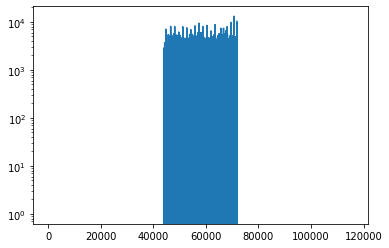

In [237]:
binary = fileToBinary('Data_Files/Holiday.txt')
hamming_code = Hamming74(binary)
symbols = qpsk(hamming_code)
ofdm_double_symbol, number_of_ofdm_double_symbol = SchmidlCox(symbols[:((max_freq-min_freq)//2)])
ofdm_symbols, number_of_ofdm_symbols = ofdmSymbols(symbols[((max_freq-min_freq)//2):])
x = save_transmit2((Pause(1), ofdm_double_symbol, ofdm_symbols, Pause(1)), True, location)
#x = np.concatenate([Pause(1), ofdm_double_symbol, ofdm_symbols, Pause(1)])
logPlot(x)
print(len(Pause(1)))
#logPlot(ofdm_double_symbol)

<ipython-input-236-3f1850bf9176>:221: RuntimeWarning: invalid value encountered in true_divide
  M = abs(P/R)**2


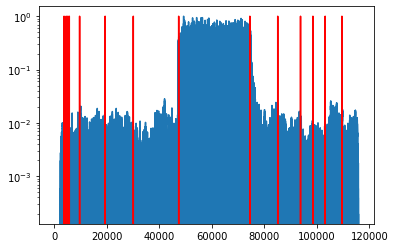

In [238]:
y = audioDataFromFile('recorded_data_' + location + '.wav')
# calculate metric M
#y = x

# detect peak of M

def getStartIndex(y, L = L, K = K):
    M = getM(y)
    convolved_M = np.convolve(M, np.ones(K) / K, 'same')
    dM = np.diff(convolved_M)
    crossed_x_axis = dM[:-1] * dM[1:]
    start_index = np.zeros(len(dM))
    i = 1
    while i < len(dM)-1:
        if crossed_x_axis[i] <= 0 and M[i] > 0.8:
            start_index[i] = 1
            i += L
        i += 1
    return start_index

start_index = getStartIndex(y)


plt.yscale('log')
plt.plot((y)/max(y))
plt.plot(start_index, color='red')